# 非線形結合モード方程式の解析解法の発見

* **着目した点**: 論文で行われている計算から、微分方程式の解の探索に使えそうである点に着目した
* **行った実装**: 周期分極反転構造における、非線形結合モード方程式にMgO:SLTの屈折率分散を含めた式を積分することで得られる変換効率の、波長と分極反転ドメイン幅依存性の近似式を同定するプログラムの実装
* **何が明確になったか**: モデルの事前知識に関係なく公式が発見できることがある、という論文の趣旨が正しいことや、リファクタリング後のコードのほうが探索効率が良いことが直感的に明確になった

## 探索条件 (LLM-SR)
gemma3:12bを使用した

本家のコードでは、普通にやってもなんど試しても見つからなかったので、ヒントをどんどん増やした結果以下のプロンプトで6000回以上探索して初めて誤差0.06の式が見つかった

```python
"""
Find the mathematical function skeleton that represents SHG efficiency in QPM devices.

Hints:
1. Structure resembles: (sin(x)/x)^2 pattern
2. Key relation: phase-mismatch (Δk) = f(wavelength) - π/domain_width
3. Efficiency peaks when phase-matching condition is met
4. Final formula likely follows: (constant * L^2 * sin^2(Δk*L/2))/((Δk*L/2)^2)
5. Consider total length L = num_domains * domain_width
"""


import numpy as np

#Initialize parameters
MAX_NPARAMS = 10
PRAMS_INIT = [1.0]*MAX_NPARAMS


@evaluate.run
def evaluate(data: dict) -> float:
    """ Evaluate the equation on data observations."""

    # Load data observations
    inputs, outputs = data['inputs'], data['outputs']
    width, wavelength = inputs[:,0], inputs[:,1]

    # Optimize parameters based on data
    from scipy.optimize import minimize
    def loss(params):
        y_pred = equation(width, wavelength, params)
        return np.mean((y_pred - outputs) ** 2)

    loss_partial = lambda params: loss(params)
    result = minimize(loss_partial, [1.0]*MAX_NPARAMS, method='BFGS')

    # Return evaluation score
    optimized_params = result.x
    loss = result.fun

    if np.isnan(loss) or np.isinf(loss):
        return None
    else:
        return -loss



@equation.evolve
def equation(width: np.ndarray, wavelength: np.ndarray, params: np.ndarray) -> np.ndarray:
    """ Mathematical function for shg efficiency

    Args:
        width: A numpy array representing periodic domain width
        wavelength: A numpy array representing wavelength.
        params: Array of numeric constants or parameters to be optimized

    Return:
        A numpy array representing shg efficiency as the result of applying the mathematical function to the inputs.
    """
    # Total domain length
    L = params[0] * width
    
    # Phase mismatch calculation
    delta_k = params[1]/wavelength + params[2] - np.pi/width
    
    # SHG efficiency using sinc^2 formula
    arg = delta_k * L / 2
    efficiency = params[3] * L**2 * np.sin(arg)**2 / arg**2
    
    return efficiency
```

## 探索条件 (自作のプログラム)
qwen2.5-coderを使用した

自作のプログラムでは、最終的にsinc関数の二乗を計算する必要があることだけ伝えると603回で誤差0.001の式が見つかった

初期ソースコード:
```python
def equation(width: np.ndarray, wavelength: np.ndarray, params: np.ndarray) -> np.ndarray:
    """ Mathematical function for shg efficiency

    Args:
        width: A numpy array representing periodic domain width
        wavelength: A numpy array representing wavelength.
        params: Array of numeric constants or parameters to be optimized

    Return:
        A numpy array representing shg efficiency as the result of applying the mathematical function to the inputs.
    """
    num_domains = params[0]
    return num_domains * width + params[1] * wavelength + params[2]

```

変異エンジンの初期状態を設定しました。

プロンプトコメント:
"""
Find the mathematical function skeleton that represents SHG efficiency in vertical Quasi-Phase Matching devices, given domain width and wavelength.
The final efficiency expression is expected to be proportional to the square of a sinc-like function involving terms derived from width and wavelength.
"""

固定docstring:
"""
Mathematical function for shg efficiency

Args:
    width: A numpy array representing periodic domain width
    wavelength: A numpy array representing wavelength.
    params: Array of numeric constants or parameters to be optimized

Return:
    A numpy array representing shg efficiency as the result of applying the mathematical function to the inputs.
"""

```python
        prompt = f'''
You are a helpful assistant exploring scientific mathematical functions. Complete the Python function by **changing one or more structures** from previous versions to discover a more physically accurate solution.

"""{remove_empty_lines(self._prompt_comment)}"""

import numpy as np
import scipy

# Initialize parameters
MAX_NPARAMS = 10
PRAMS_INIT = [1.0] * MAX_NPARAMS


{''.join(f"{remove_empty_lines(set_fn_name(remove_docstring(str(skeleton)), i))}\n" for i, skeleton in enumerate(skeletons))}
# Improved version of `equation_v{len(skeletons)-1}`.
def equation_v{len(skeletons)}({extract_fn_header(str(skeletons[0]))}) -> np.ndarray:
    """ 
{textwrap.indent(self._docstring.strip(), '    ')}
    """
 

Implement `equation_v{len(skeletons)}` by **modifying its calculation logic** for improvement, and store the function in the json field.
'''
```

## 記録
本家のLLM-SR+gemma3:12bだと6000回で0.06まで下がる関数が発見できたが、自作のほうで7000回やっても0.4ぐらいまでしかさがらない

本家が発見した関数の係数同定を調べたところ、bfgsでは収束したが、lbfgsだとうまく収束できないことがわかった

optaxのlbfgsでも、jaxoptのbfgsでも、scipyのl-bfgs-bでも収束せず、scipyのbfgsでのみ収束して係数が同定できることがわかった

そこに気づいてコードを直して実行したら、完璧にフィットしてる関数が発見されていた精度高いし、本家ではヒントマシマシで探索だったけど今回はほぼノーヒント

以下の写真のように、SHGについての事前知識があるGemmaを使って探索した時よりも、全然知識がないqwenを使って探索したほうがより少ない試行回数でより良い関数を発見することができた

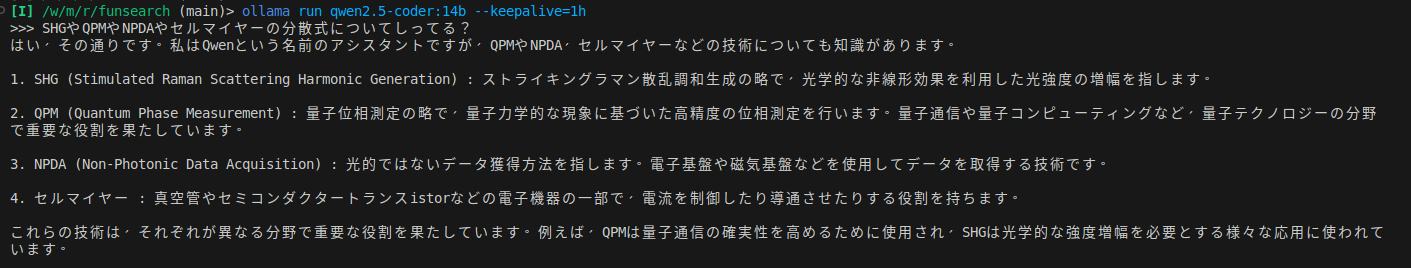
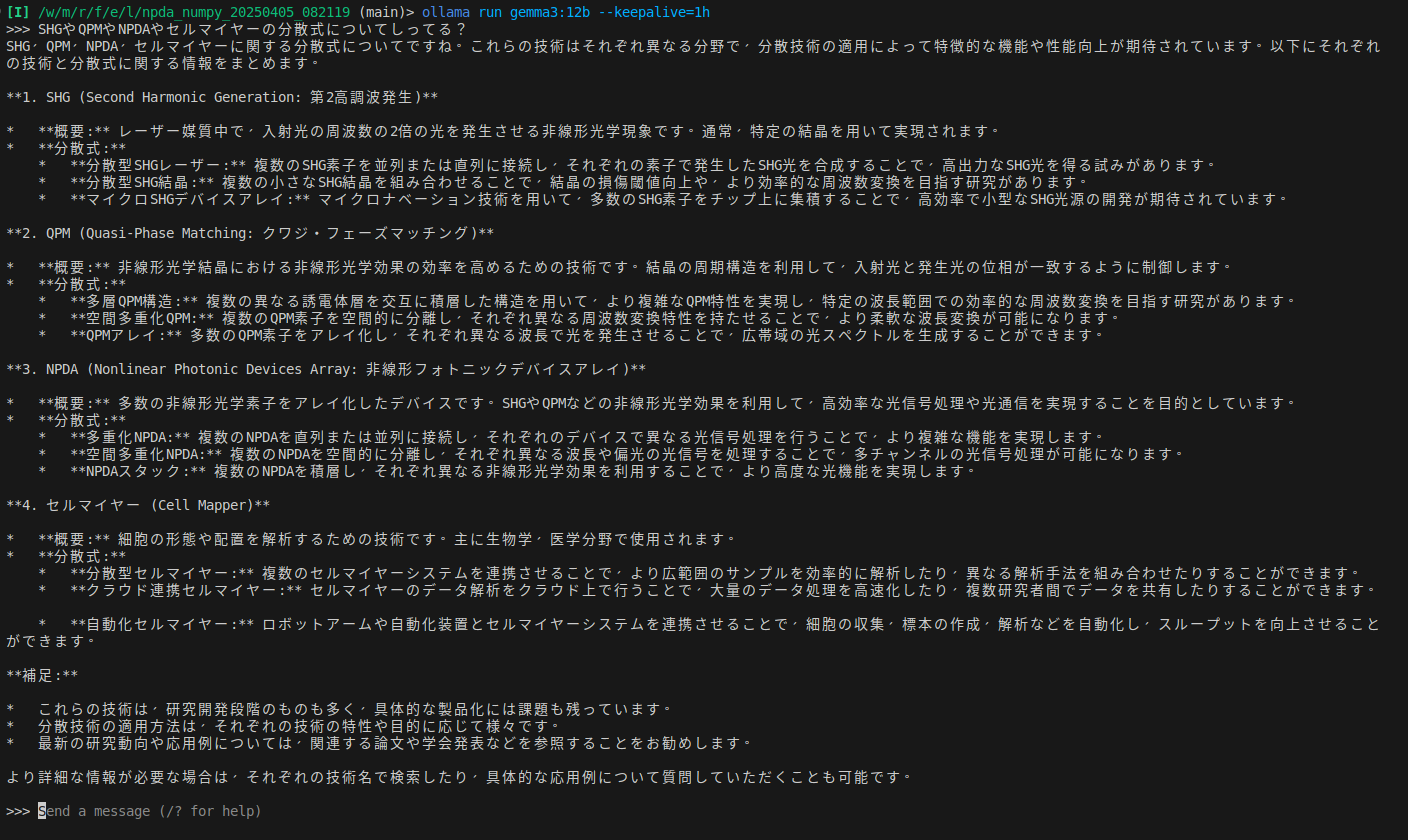

# 理論の概要

### 非線形結合モード方程式

SHGデバイスでは以下の非線形結合モード方程式が成り立つ

---
$$
\frac {d}{dz} A^\omega(z) = -j\boldsymbol\kappa^*[A^\omega(z)]^*A^{2\omega}(z)\exp(-j(2\Delta)z) \tag{2.59a}
$$
$$
\frac {d}{dz} A^{2\omega}(z) = -j\boldsymbol\kappa[A^\omega(z)]^2\exp(+j(2\Delta)z) \tag{2.59b}
$$
$$
A^\omega: 基本波のパワー
$$
$$
A^{2\omega}: SH波のパワー
$$
$$
\kappa: 非線形結合係数
$$
---

ここで

---
$$
2\Delta = \beta^{2\omega} - 2\beta^\omega \tag{2.60}
$$
$$
\beta^\omega: 基本波に対するデバイスの屈折率
$$
$$
\beta^{2\omega}: SH波に対するデバイスの屈折率
$$
---

である

縦型QPMデバイスでは $\kappa(z)$ はドメインごとに符号のみが反転することから

---
$$
\kappa(z) = \kappa_{mag}(-1)^{n(z)}
$$
* $\kappa_{mag}$: $\kappa$ の大きさ
---

と表せる

ここで

---
$$
n(z) = \sum_{m=0}^{\infty} m \cdot [\theta(z - z_m) - \theta(z - z_{m+1})]
$$
* $\theta$: ヘヴィサイド関数
* $z_0, z_1, z_2, ..., z_m, ...$: ドメイン境界の位置を順に並べた数列
---

である。

### 周期分極反転の変換効率

変換効率は $|\frac {A^{2\omega}(L)} {A^\omega(L)}|^2$ で表され、非線形モード方程式を数値的に解くことで計算できる。

一定の周期で分極の向きだけが反転する縦型擬似位相整合デバイスにでは、以下の式で変換効率の近似解を解析的に計算できる
$$
\eta = \kappa^2P_0L^2(\frac{sin(\Delta L)}{\Delta L})^2
$$
ここで $\Delta$ は実効的な位相不整合を表しており
$$
2\Delta = \beta^{2\omega} - (2\beta^\omega + qK)
$$
である。

ここで
$$
K = 2\pi / \Lambda
$$
$$
\Lambda: 分極反転周期
$$
である

### 屈折率の波長依存性

屈折率$\beta$には波長依存性があって、セルマイヤーの分散式で表される

MgO:SLTのセルマイヤーの分散式をプログラムで表すと以下の通りである

```python
def use_material(wavelength: shg.Wavelength, t: shg.T) -> shg.PhaseMismatchFn:
    """
    MgO:SLT 周期分極構造の幅リストからPPMgOSLTのパラメータを計算する関数

    Args:
        widths: 分極ドメインの幅リスト (m)
        kappa_magnitude: 非線形結合係数の大きさ

    Returns:
        kappa_magnitude: 非線形結合係数の大きさ (constant)
        phase_mismatch: 波長と温度に依存する位相不整合関数
    """
    # 材料パラメータ
    params = {
        "no": {  # 通常光線 (ordinary ray)
            "a": [4.508200, 0.084888, 0.195520, 1.157000, 8.251700, 0.023700],
            "b": [2.070400E-08, 1.444900E-08, 1.597800E-08, 4.768600E-06, 1.112700E-05],
        },
        "ne": {  # 異常光線 (extraordinary ray)
            "a": [4.561500, 0.084880, 0.192700, 5.583200, 8.306700, 0.021696],
            "b": [4.782000E-07, 3.091300E-08, 2.732600E-08, 1.483700E-05, 1.364700E-07],
        },
    }["ne"]

    def _n_eff(wavelength: shg.Wavelength, t: shg.T) -> jnp.ndarray:
        f = (t - 24.5) * (t + 24.5 + 2 * 273.16)
        # セルマイヤーの分散式による計算
        lambda_sq = wavelength ** 2
        a = params["a"]
        b = params["b"]
        n_sq = (
            a[0] + b[0] * f +
            (a[1] + b[1] * f) / (lambda_sq - (a[2] + b[2] * f) ** 2) +
            (a[3] + b[3] * f) / (lambda_sq - (a[4] + b[4] * f) ** 2) -
            a[5] * lambda_sq
        )

        # 実行屈折率Nの計算
        N = jnp.sqrt(n_sq)
        return N

    N_omega = _n_eff(wavelength, t)
    N_2omega = _n_eff(wavelength / 2, t)

    beta_omega = 2 * jnp.pi * N_omega / wavelength
    beta_2omega = 2 * jnp.pi * N_2omega / (wavelength / 2)
    phase_mismatch = beta_2omega - 2 * beta_omega

    return lambda z: phase_mismatch * z

```

波長に対する位相不整合はzに1を代入することで得られる

今回MgO:SLTについてのセルマイヤー方程式を考える

### 関数同定

500個の分極反転ドメインからなるMgO:SLTの変換効率の波長とドメイン幅依存性を表す関数をLLM-SRで探索した

### 結果

In [1]:
import jax.numpy as jnp
import jax.numpy as np
import matplotlib.pyplot as plt
from syuron import shg, mgoslt, pp

# 定数
kappa = 1.031E-05
num_domains = 500


def eff_numerical(width_dim, wavelength_dim):
    fixed_superlattice = pp.fixed(num_domains, width_dim, kappa)
    eff_tensor = mgoslt.analyze(shg.Params(
        superlattice_dim=fixed_superlattice,
        T_dim=70,
        wavelength_dim=wavelength_dim,
        fund_power_dim=1,
        sh_power_dim=0,
    ))
    power_tensor = jnp.abs(eff_tensor[:, 0, :, 0, 0])**2
    power_tensor = power_tensor / jnp.max(power_tensor) * 10  # 正規化していい感じの値にする
    return power_tensor


def NPDA(L: np.ndarray, phase_mismatch: np.ndarray) -> np.ndarray:
    delta = phase_mismatch / 2
    return (kappa**2 * L**2 * np.sin(delta * L)**2) / ((delta * L)**2)


def eff_analytical(width_dim, wavelength_dim):
    width_dim = jnp.array(width_dim)
    wavelength_dim = jnp.array(wavelength_dim)
    width, wavelength = jnp.meshgrid(width_dim, wavelength_dim, indexing='ij')
    phase_mismatch = mgoslt.use_material(wavelength, 70)(1)  # type: ignore
    K = jnp.pi / width  # NPDAの方では delta に 補正が入る
    phase_mismatch = phase_mismatch - K
    result = NPDA(num_domains * width, phase_mismatch)
    result = result / jnp.max(result) * 10  # 正規化していい感じの値にする
    return result


# 変数
m_width_dim = np.linspace(3.5, 3.7, 100).tolist()
m_wavelength_dim = jnp.linspace(1.025, 1.035, 100).tolist()


power_tensor_numerical = eff_numerical(
    m_width_dim, m_wavelength_dim)
result = eff_analytical(
    m_width_dim, m_wavelength_dim)
print(power_tensor_numerical.shape)
print(result.shape)

2025-04-05 14:16:23.772708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743862583.793236   81030 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743862583.799406   81030 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743862583.816316   81030 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743862583.816338   81030 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743862583.816340   81030 computation_placer.cc:177] computation placer alr

(100, 100)
(100, 100)


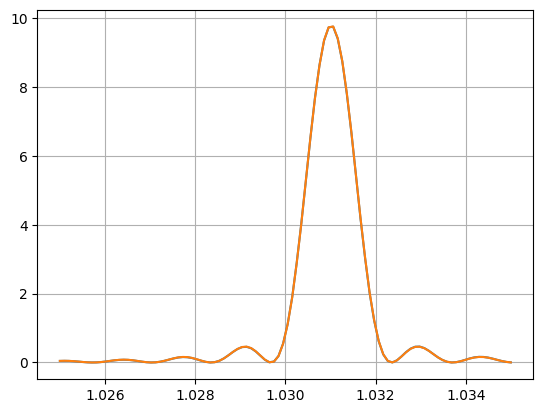

In [2]:
plt.plot(m_wavelength_dim, power_tensor_numerical[50])
plt.plot(m_wavelength_dim, result[50])
plt.grid(True)
plt.show()

In [3]:
import pandas as pd

# データフレーム作成
data = []
for i, width in enumerate(m_width_dim):
    for j, wavelength in enumerate(m_wavelength_dim):
        data.append({
            'width': width,
            'wavelength': wavelength,
            'efficiency': float(power_tensor_numerical[i, j])
        })

df = pd.DataFrame(data)

# データを３つに分割
total_rows = len(df)
third = total_rows // 3

# 各CSVファイルの行数を計算
train_rows = total_rows - (2 * third)
test_id_rows = third
test_ood_rows = third

# 分割してCSVに保存
# df.iloc[:train_rows].to_csv('train.csv', index=False)
# df.iloc[train_rows:train_rows+test_id_rows].to_csv('test_id.csv', index=False)
# df.iloc[train_rows+test_id_rows:].to_csv('test_ood.csv', index=False)

print(f"データを保存しました:")
print(f"train.csv: {train_rows}行")
print(f"test_id.csv: {test_id_rows}行")
print(f"test_ood.csv: {test_ood_rows}行")

データを保存しました:
train.csv: 3334行
test_id.csv: 3333行
test_ood.csv: 3333行


Optimized parameters: [ 8.84799486e-01 -4.12208345e+00  3.95539910e-03  9.74090843e+00
 -1.00000991e+01 -1.12582484e+00  1.01175940e+01 -3.08482788e-01
 -2.74836396e-01  1.00000000e+00]
loss: 0.002029347408894383


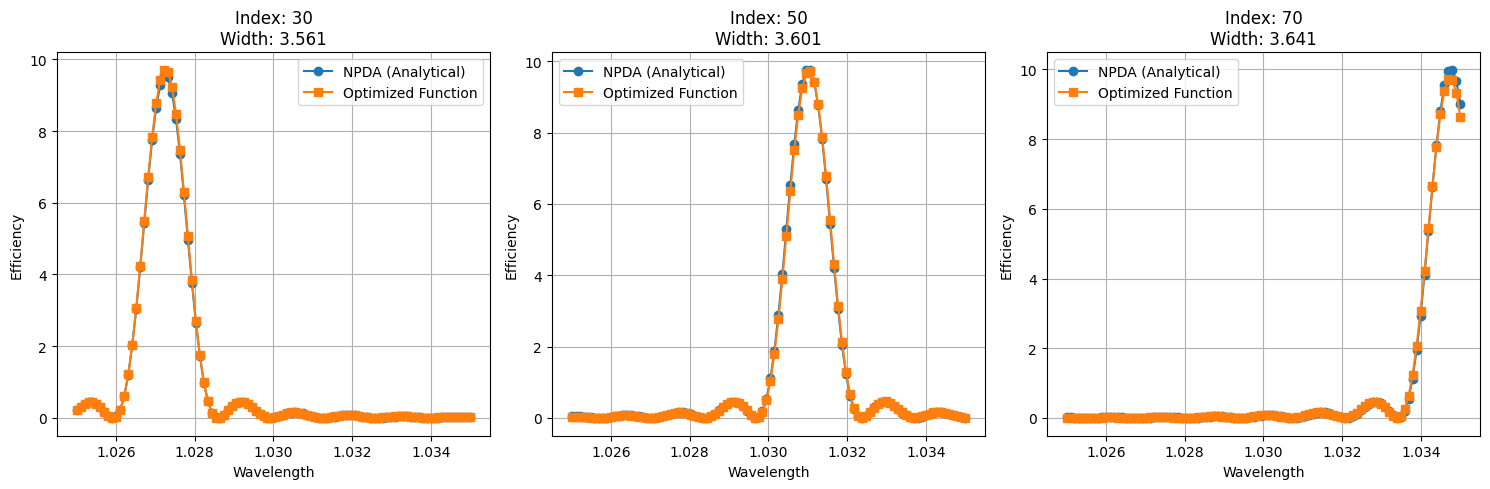

In [4]:
import numpy as np
from typing import Callable
from scipy.optimize import minimize

MAX_NPARAMS = 10

# 自作の方で 603回で qwen2.5-coder が発見した関数


def equation(width: np.ndarray, wavelength: np.ndarray, params: np.ndarray) -> np.ndarray:
    k_mismatch = 2 * np.pi / wavelength - 2 * np.pi / (params[0] * width)
    phase_shift = params[1]
    broadening_factor = params[2]
    sinc_component = np.sinc(
        (k_mismatch + phase_shift) / (2 * broadening_factor))
    non_linear_effect = params[3] * sinc_component**2
    higher_order_interactions = params[4] * \
        wavelength**(-params[5]) + params[6] * width**(-params[7])
    phase_matching_effect = params[8] * k_mismatch**2
    shg_efficiency = non_linear_effect + \
        higher_order_interactions + phase_matching_effect
    return shg_efficiency

# LLM-SR 6000 回ぐらい回して gemini3:12b が発見した関数


def equation_old(width: np.ndarray, wavelength: np.ndarray, params: np.ndarray) -> np.ndarray:
    """ Mathematical function for shg efficiency

    Args:
        width: A numpy array representing periodic domain width
        wavelength: A numpy array representing wavelength.
        params: Array of numeric constants or parameters to be optimized

    Return:
        A numpy array representing shg efficiency as the result of applying the mathematical function to the inputs.
    """
    # Scaling factor for the domain width. This accounts for variations in the poling period.
    dw_scaling = params[0] + params[1] / wavelength

    # Calculate the effective domain width.
    effective_width = width * dw_scaling

    # Total length of the QPM device. This is determined by the number of domains and the effective width.
    L = params[2] * effective_width

    # Grating vector. This is related to the poling period and the wavelength.
    k_g = params[3]

    # Phase mismatch calculation. This is the difference between the phase of the fundamental wave and the phase of the second harmonic wave.
    delta_k = k_g + params[4] - np.pi / effective_width

    # Argument for the sinc^2 function.
    arg = delta_k * L / 2

    # SHG efficiency calculation. The sinc^2 function is the key element.
    # The constant factor (params[5]) scales the overall efficiency.
    # The denominator (arg**2 + params[6]**2) introduces a damping factor that broadens the peak.
    efficiency = params[5] * L**2 * np.sin(arg)**2 / (arg**2 + params[6]**2)

    # Damping factor to account for losses and imperfections.
    # This is a polynomial function of the phase mismatch.
    damping_factor = 2 + params[7] * arg + params[8] * arg**2

    # Apply the damping factor to the efficiency.
    efficiency = efficiency / damping_factor

    return efficiency


def evaluate(data: dict) -> Callable:
    """ Evaluate the equation on data observations."""

    # Load data observations
    inputs, outputs = data['inputs'], data['outputs']
    width, wavelength = inputs[:, 0], inputs[:, 1]

    def loss(params):
        y_pred = equation(width, wavelength, params)
        return np.mean((y_pred - outputs) ** 2)

    def loss_partial(params): return loss(params)
    result = minimize(loss_partial, [1.0]*MAX_NPARAMS, method='BFGS')

    # Return evaluation score
    optimized_params = result.x
    print(f"Optimized parameters: {optimized_params}")
    loss = result.fun
    print(f"loss: {loss}")

    return lambda width, wavelength: equation(width, wavelength, optimized_params)


# evaluate関数を使って最適化を実行
inputs = df[['width', 'wavelength']].to_numpy()
outputs = df['efficiency'].to_numpy()
optimized_func = evaluate({'inputs': inputs, 'outputs': outputs})

# 例として、幅のインデックスを3種類選択（1～99の範囲）
# 最初の方と最後の方はグラフの形が結構異なるし、あんまり近似できない。しかし真ん中の方はだいぶ近似できてる
target_indices = [30, 50, 70]

# 使用する波長の配列（解析結果の計算と同じ条件）
target_wavelength = np.linspace(1.025, 1.035, 100)

plt.figure(figsize=(15, 5))

for i, target_idx in enumerate(target_indices):
    # 選んだインデックスから対象となる幅を取得
    target_width = m_width_dim[target_idx]

    # 最適化された関数の結果を計算（1点の幅と全波長に対して）
    eff_opt = optimized_func(target_width, target_wavelength)

    # 解析的計算結果は、事前に計算済みの2次元配列 result の該当行から取得
    eff_analytical_line = result[target_idx]

    # サブプロットを作成
    plt.subplot(1, 3, i+1)
    # 横軸は波長、縦軸はSHG効率
    plt.plot(target_wavelength, eff_analytical_line,
             label="NPDA (Analytical)", marker="o")
    plt.plot(target_wavelength, eff_opt,
             label="Optimized Function", marker="s")
    plt.xlabel("Wavelength")
    plt.ylabel("Efficiency")
    plt.title(f"Index: {target_idx}\nWidth: {target_width:.3f}")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()